# Neutral Network MNIST fashion - exercise with validation

As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes

In [16]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper
import matplotlib.pyplot as plt

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [23]:
# Defining network architecture
# 784 input units (28x28 images)
# 256 hiden layer -ReLU activation function
# 128 hiden layer -ReLU activation function
# 64 hiden layer -ReLU activation function
# 10 output layer for each class (10 classes) - Log-softmax function
# nn.Dropout module used to reduce overfitting, where input unit will be randomly dropped 

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,10)
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        # Make sure that input tensor is flattened into 784 long vector
        x = x.view(x.shape[0],-1)
    
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        # no dropout for output
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
        

In [24]:
# During inference we want to use the entire network (no dropout).
# Turn off dropout for: validation, testing, any predictions with model.eval() for which the dropout probability is 0
# Turning on the dropout back with model.train()

In [40]:
model = Classifier()
# Definig the loss with the negative log likehood loss.(Loss - distance between the true and predicted values)
criterion = nn.NLLLoss()

# Checked also and loss is bigger for optim.SGD lr = 0.001 (for epoch 5 is 0.48467831648806775).
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
train_losses, test_losses = [], []
# Training the network.
for e in range(epochs):
    running_loss = 0    
    for image, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(image)
        
        # Calculating the loss with the outputs and the labels.
        loss = criterion(log_ps, labels)
        
        # Calculating the gradients for the parameters.
        loss.backward()
        
        # Taking an update step and few the new weights.
        optimizer.step()
        
        running_loss +=loss.item()
        
    else:
        # Implementing the validation pass and printing out the validation accuracy.
        # Goal of validation: measure the model performance on the test dataset - here as calculating the accuracy
        # Turn off gradients - speeding up the code, as there will be no update of parameters in validation pass.
        test_loss = 0
        accuracy = 0
        with torch.no_grad(): 
            # During inference the entire network is used, so no dropout
            #model.eval() - sets the model to evaluation mode where dropout probability is 0
            model.eval()
            for image, labels in testloader:
                log_ps = model(image)
                test_loss += criterion(log_ps, labels)
                
                # Get the class probabilities
                ps = torch.exp(log_ps)
                
                # Getting the most likely class using the ps.topk method - returns a tuple of the top-k values and the top-kindices
                top_p, top_class = ps.topk(1,dim=1)
                
                #Check if the predicted classes match the labels
                equals = top_class==labels.view(*top_class.shape)
                
                #calculate the percentage of correct predictions
                #convert equals to a float tensor from torch.ByteTensor
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()
        
    train_losses.append(test_loss/len(testloader))
    test_losses.append(running_loss/len(trainloader))
    #torch.mean returns a scalar tensor, to get the actual value as a float we'll need to do accuracy.item()
        
    print("Epoch {} / {}".format(e+1, epochs),
            "Training loss: {:.3f}".format(running_loss/len(trainloader)),
             "Testing loss: {:.3f}".format(test_loss/len(testloader)),
             "Accuraccy {:.2f} %".format(accuracy.item()/len(testloader)*100))       
            
            

Epoch 1 / 30 Training loss: 0.607 Testing loss: 0.496 Accuraccy 82.81 %
Epoch 2 / 30 Training loss: 0.485 Testing loss: 0.470 Accuraccy 83.17 %
Epoch 3 / 30 Training loss: 0.453 Testing loss: 0.417 Accuraccy 84.52 %
Epoch 4 / 30 Training loss: 0.433 Testing loss: 0.442 Accuraccy 84.32 %
Epoch 5 / 30 Training loss: 0.421 Testing loss: 0.419 Accuraccy 85.22 %
Epoch 6 / 30 Training loss: 0.413 Testing loss: 0.403 Accuraccy 85.50 %
Epoch 7 / 30 Training loss: 0.400 Testing loss: 0.395 Accuraccy 85.67 %
Epoch 8 / 30 Training loss: 0.402 Testing loss: 0.395 Accuraccy 85.14 %
Epoch 9 / 30 Training loss: 0.398 Testing loss: 0.417 Accuraccy 85.04 %
Epoch 10 / 30 Training loss: 0.393 Testing loss: 0.390 Accuraccy 86.63 %
Epoch 11 / 30 Training loss: 0.386 Testing loss: 0.393 Accuraccy 86.23 %
Epoch 12 / 30 Training loss: 0.383 Testing loss: 0.385 Accuraccy 86.51 %
Epoch 13 / 30 Training loss: 0.380 Testing loss: 0.385 Accuraccy 86.46 %
Epoch 14 / 30 Training loss: 0.375 Testing loss: 0.390 Accur

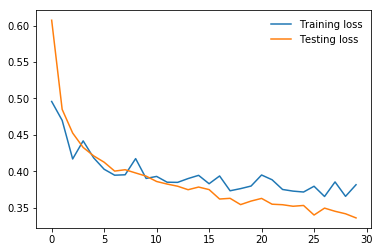

In [41]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Testing loss")
plt.legend(frameon=False)

In [45]:
torch.cuda.is_available()

False

In [44]:
torch.cuda.device_count()

0